In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [2]:
# Global definitions
os.chdir('C:/')
base_folder = os.getcwd()
parent_folder = os.path.dirname(base_folder)
data_folder = os.path.join(parent_folder, "data")
path = data_folder + '/rare_species 1/'
df = pd.read_csv(data_folder + r'\rare_species 1\metadata.csv')
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [3]:
# controlling randomness
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Image size definition
image_size = (224, 224) 
X = []
y = []

In [5]:
def load_and_resize_image(image_path, target_size=image_size):
    image = tf.io.read_file(path + '/' + image_path) # get the image 
    image = tf.image.decode_jpeg(image, channels=3) # decode that into an jped channels 3 means RGB 
    image = tf.image.resize(image, target_size) # resize- so sequential can accept it
    image = image / 255.0 # 0/1 format 
    return image

In [6]:
# Sample 
temp = df.sample(n=2000, random_state=42)

In [7]:
for i in range(len(temp)):
    img = load_and_resize_image(temp.iloc[i]['file_path'], target_size=image_size)
    X.append(img)
    y.append(temp.iloc[i]['family'])

In [8]:
# Encode and split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train/val/test 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 1200
Validation set size: 400
Test set size: 400


In [9]:
#everything to np array
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()

# First convolutional block 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # 224x224 RGB images
model.add(MaxPooling2D(pool_size=(2, 2)))

#Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolutional block
#model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Fivth convolutional block
#model.add(Conv2D(512, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer for regularization

model.add(Dense(256, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



C:\Users\EDUAR\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
boynextdoor = model.fit(X_train, y_train, 
                        epochs=10, batch_size=32, 
                        validation_data=(X_val, y_val))


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 924ms/step - accuracy: 0.0213 - loss: 6.0153 - val_accuracy: 0.0300 - val_loss: 5.1851
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 920ms/step - accuracy: 0.0338 - loss: 5.1094 - val_accuracy: 0.0375 - val_loss: 5.1943
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 926ms/step - accuracy: 0.0504 - loss: 4.9863 - val_accuracy: 0.0425 - val_loss: 5.1778
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 939ms/step - accuracy: 0.0770 - loss: 4.7493 - val_accuracy: 0.0650 - val_loss: 5.1488
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 933ms/step - accuracy: 0.1481 - loss: 4.1680 - val_accuracy: 0.0675 - val_loss: 5.7478
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 912ms/step - accuracy: 0.3188 - loss: 3.0872 - val_accuracy: 0.0625 - val_loss: 6.3301
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 912ms/step - accuracy: 0.5356 - loss: 2.0933 - val_accuracy: 0.0750 - val_loss: 6.4935
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 912ms/step - accuracy: 0.6544 - loss: 1.5388 - val_accu

In [12]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Test accuracy: {val_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.0283 - loss: 9.5200
Test accuracy: 0.0425


In [13]:
y_pred = model.predict(X_val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


In [14]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class index with the highest probability
y_pred_classes 


array([ 97, 169, 111,  10,  62, 142, 142,  69,  69,  32,  62, 158, 150,
       104,  79,  60,  16,   4,  60,  60,  60,  79, 142,  79, 104, 150,
       101,  12, 144, 163, 188,  60, 104, 183, 169,  69,  76, 104, 195,
       179,  78,  48, 101,  33, 104, 142,  13,  16,  19,  33,  60,  16,
       104,  12, 142,  38, 189,  60, 104, 104,  38,   2, 197, 104, 108,
        78,  16,   2,   2, 101, 186, 104, 101,  60, 104,  76,  60,  79,
       108, 104,  29, 104,  94,  16, 155, 193, 150,  38, 104, 121, 150,
       121, 111,  47, 144,  42,  60,  60, 197,  79,   5,  79,  78, 104,
        60,  11,  16, 188, 163, 104, 144,  69,  16,  52, 121,   0,  69,
        60,  33,  38, 104, 104,  13, 163,  60,  60, 142,  76,  10, 183,
        60, 111, 163, 192, 142,  38,  60,  12,  16, 104, 154,  16, 155,
       130, 104, 101, 142,  79,  38, 104,  29, 150, 144,  60, 197, 104,
         2, 144, 186,  48, 174, 183,  38,  84, 104,  33, 183, 104,  79,
       197,  79, 107,  60,  94,  79,  16, 155,  97,  60, 150,  3

In [15]:
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_val)

Total incorrect predictions: 383


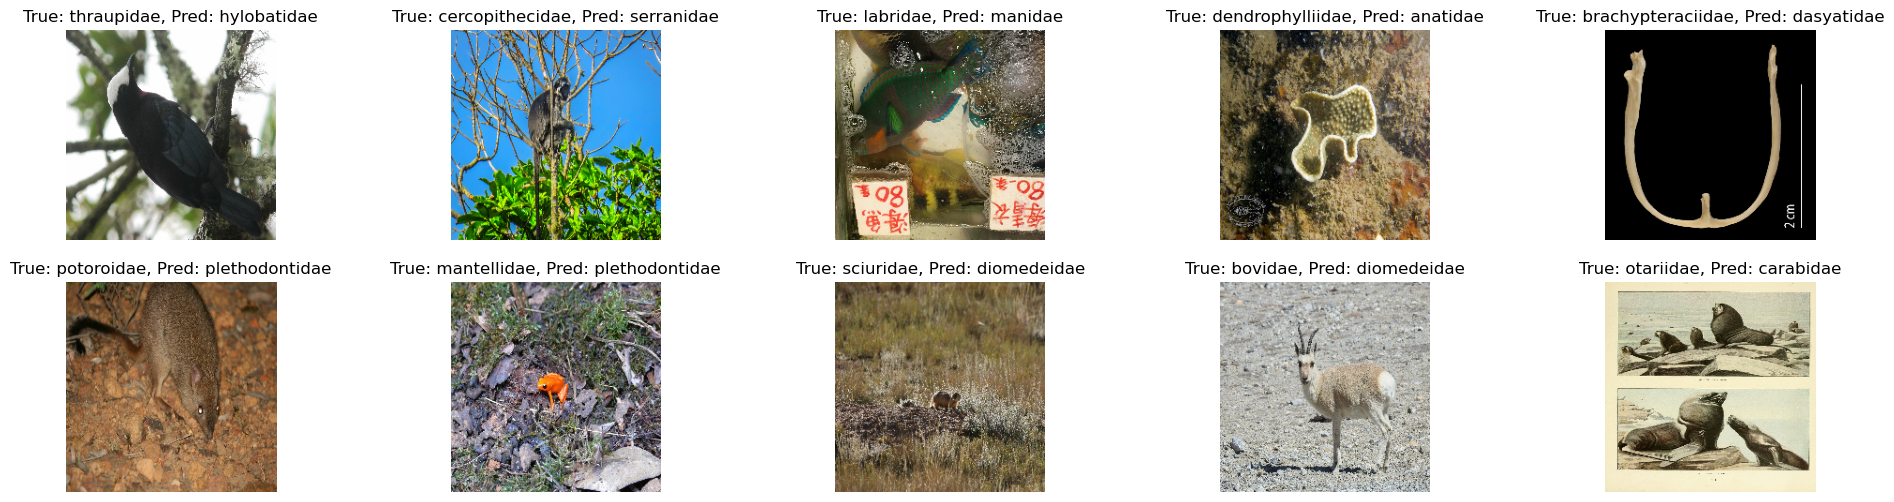

In [46]:
incorrect_indices = np.where(y_pred_labels != y_true_labels)[0]
print(f"Total incorrect predictions: {len(incorrect_indices)}")

num_samples = min(10, len(incorrect_indices))  # Show up to 10 images
plt.figure(figsize=(24, 6))

for i, idx in enumerate(incorrect_indices[:num_samples]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx])  # Display image
    plt.title(f"True: {y_true_labels[idx]}, Pred: {y_pred_labels[idx]}")
    plt.axis("off")

plt.show()


In [17]:
# To see correct predictions
correct_indices = np.where(y_pred_classes == y_val)[0]  
print(f"Total correct predictions: {len(correct_indices)}")


Total correct predictions: 17


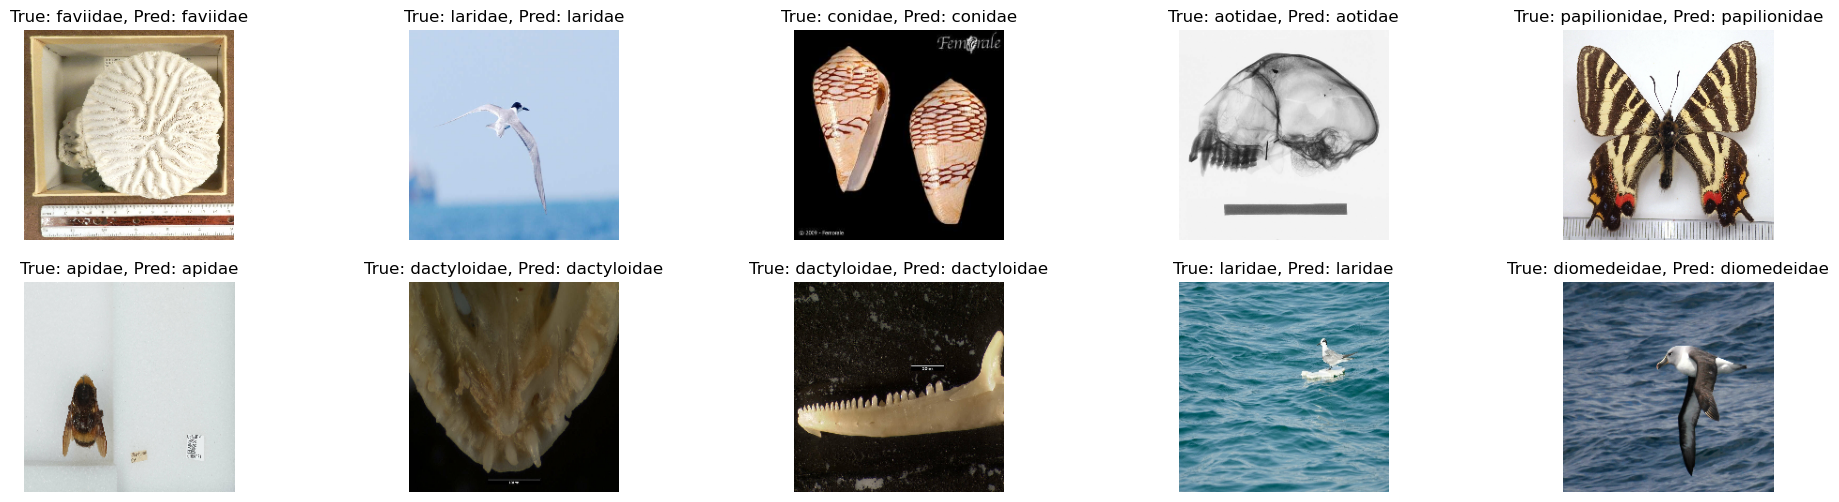

In [18]:
num_samples = min(10, len(correct_indices))  # Show up to 10 images
plt.figure(figsize=(24, 6))

for i, idx in enumerate(correct_indices[:num_samples]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx])  # Display image
    plt.title(f"True: {y_true_labels[idx]}, Pred: {y_pred_labels[idx]}")
    plt.axis("off")

plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [20]:
boynextdoor = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    epochs=10, 
    validation_data=(X_val, y_val)  
)


C:\Users\EDUAR\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0583 - loss: 6.2701 - val_accuracy: 0.0500 - val_loss: 5.1248
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0532 - loss: 4.7452 - val_accuracy: 0.0750 - val_loss: 5.0613
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0941 - loss: 4.5365 - val_accuracy: 0.0825 - val_loss: 5.0904
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0985 - loss: 4.5264 - val_accuracy: 0.0725 - val_loss: 5.1673
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1091 - loss: 4.2994 - val_accuracy: 0.0925 - val_loss: 5.1520
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1131 - loss: 4.3019 - val_accuracy: 0.0725 - val_loss: 5.1421
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1241 - loss: 4.1563 - val_accuracy: 0.1000 - val_loss: 5.1635
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1656 - loss: 3.9314 - val_accuracy: 0.1000 - val_loss:

In [21]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Test accuracy: {val_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.1027 - loss: 5.6122
Test accuracy: 0.1025


In [22]:
# Create a generator for augmented data
augmented_images = datagen.flow(X_train, y_train, batch_size=32, shuffle=False)
augmented_data, augmented_labels = next(augmented_images)  

# Combine original and augmented data
X_combined = np.concatenate((X_train, augmented_data), axis=0)
y_combined = np.concatenate((y_train, augmented_labels), axis=0)

# Train the model using both regular and augmented data
boynextdoor = model.fit(X_combined, y_combined, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 944ms/step - accuracy: 0.5255 - loss: 2.1511 - val_accuracy: 0.0850 - val_loss: 7.6550
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 901ms/step - accuracy: 0.8354 - loss: 0.7096 - val_accuracy: 0.0850 - val_loss: 9.7624
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 903ms/step - accuracy: 0.9081 - loss: 0.4217 - val_accuracy: 0.1000 - val_loss: 9.8655
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 888ms/step - accuracy: 0.9267 - loss: 0.3431 - val_accuracy: 0.0825 - val_loss: 10.3769
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 907ms/step - accuracy: 0.9213 - loss: 0.4102 - val_accuracy: 0.0725 - val_loss: 10.6336
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 910ms/step - accuracy: 0.9519 - loss: 0.2032 - val_accuracy: 0.0850 - val_loss: 11.5780
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 898ms/step - accuracy: 0.9668 - loss: 0.1646 - val_accuracy: 0.0800 - val_loss: 11.1592
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 908ms/step - accuracy: 0.9723 - loss: 0.1357 - val_

In [23]:
len(X_combined)

1232

In [24]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Test accuracy: {val_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.0679 - loss: 12.5305
Test accuracy: 0.0825


In [25]:
#model.save("keras_model_v1.keras")